In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor   # using this for the baseline as required


In [2]:
file = "marks_dataset.xlsx"
xls = pd.ExcelFile(file)

dfs = []
for s in xls.sheet_names:
    d = pd.read_excel(file, sheet_name=s)
    d['sheet_id'] = s
    dfs.append(d)
df = pd.concat(dfs, ignore_index=True)
df.columns = [c.strip() for c in df.columns]
useful_cols = [
    "As:1","As:2","As:3","As:4",
    "Qz:1","Qz:2","Qz:3","Qz:4","Qz:5","Qz:6",
    "S-I:1","S-I:2","S-I:3","S-I",
    "S-II:1","S-II:2","S-II:3","S-II",
    "Final:1","Final:2","Final:3","Final:4","Final:5","Final"
]
keep = [c for c in useful_cols if c in df.columns]
df = df[keep].copy()


In [10]:
# 3) Simple missing-value handling (median imputation)
for col in df.columns:
    if df[col].isna().any():
        med = df[col].median()
        df[col] = df[col].fillna(med) 

In [4]:
# Train/test split
def split_data(df, test_ratio=0.2):
    df = df.sample(frac=1, random_state=1).reset_index(drop=True)
    test_size = int(len(df) * test_ratio)
    test = df[:test_size]
    train = df[test_size:]
    return train, test

# Add bias (intercept)
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

# Manual Linear Regression
def fit_reg(X, y):
    XtX = X.T @ X
    XtY = X.T @ y
    beta = np.linalg.inv(XtX) @ XtY
    return beta

def predict(X, beta):
    return X @ beta

# Metrics
def MAE(y, yhat): return np.mean(np.abs(y - yhat))
def RMSE(y, yhat): return np.sqrt(np.mean((y - yhat)**2))
def R2(y, yhat):
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - ss_res/ss_tot

# Bootstrapping for MAE CI
def bootstrap_mae(X_train, y_train, n=500):
    maes = []
    N = len(X_train)
    for i in range(n):
        idx = np.random.choice(N, N, replace=True)
        Xb = X_train[idx]
        yb = y_train[idx]
        beta = fit_reg(Xb, yb)
        pred_b = predict(Xb, beta)
        maes.append(MAE(yb, pred_b))
    maes = np.array(maes)
    return maes.mean(), (np.percentile(maes, 2.5), np.percentile(maes, 97.5))


In [5]:
#  RQ1
rq1_feats = [
    "As:1","As:2","As:3","As:4",
    "Qz:1","Qz:2","Qz:3","Qz:4","Qz:5","Qz:6",
    "S-I:1","S-I:2","S-I:3"
]
rq1_feats = [f for f in rq1_feats if f in df.columns]

target = "S-I"

data1 = df[rq1_feats + [target]].copy()
train, test = split_data(data1)

X_train = train[rq1_feats].values
y_train = train[target].values
X_test  = test[rq1_feats].values
y_test  = test[target].values

# Pick best predictor
cors = {c: abs(np.corrcoef(train[c], y_train)[0,1]) for c in rq1_feats}
best_feat = max(cors, key=cors.get)

# ---- SIMPLE MODEL ----
X1_train = add_bias(train[[best_feat]].values)
X1_test  = add_bias(test[[best_feat]].values)

beta1 = fit_reg(X1_train, y_train)
y1_train_pred = predict(X1_train, beta1)
y1_test_pred  = predict(X1_test, beta1)

boot1, ci1 = bootstrap_mae(X1_train, y_train)

# ---- MULTIPLE MODEL ----
X2_train = add_bias(X_train)
X2_test  = add_bias(X_test)

beta2 = fit_reg(X2_train, y_train)
y2_train_pred = predict(X2_train, beta2)
y2_test_pred  = predict(X2_test, beta2)

boot2, ci2 = bootstrap_mae(X2_train, y_train)

# ---- DUMMY MODEL ----
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

yd_train_pred = dummy.predict(X_train)
yd_test_pred  = dummy.predict(X_test)

rq1_results = pd.DataFrame([
    ["Simple", best_feat,
     MAE(y_train, y1_train_pred), MAE(y_test, y1_test_pred),
     RMSE(y_train, y1_train_pred), RMSE(y_test, y1_test_pred),
     R2(y_train, y1_train_pred), R2(y_test, y1_test_pred),
     boot1, ci1],

    ["Multiple", rq1_feats,
     MAE(y_train, y2_train_pred), MAE(y_test, y2_test_pred),
     RMSE(y_train, y2_train_pred), RMSE(y_test, y2_test_pred),
     R2(y_train, y2_train_pred), R2(y_test, y2_test_pred),
     boot2, ci2],

    ["Dummy", [],
     MAE(y_train, yd_train_pred), MAE(y_test, yd_test_pred),
     RMSE(y_train, yd_train_pred), RMSE(y_test, yd_test_pred),
     R2(y_train, yd_train_pred), R2(y_test, yd_test_pred),
     None, None]
], columns=["Model","Features","Train MAE","Test MAE","Train RMSE","Test RMSE","Train R2","Test R2","Boot MAE Mean","Boot 95% CI"])

rq1_results


,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,Simple,S-I:1,1.275192,1.088145,2.118205,1.429345,0.454847,0.569954,1.288871,"(1.0082987693806693, 1.6329743402542503)"
1,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",1.239809,1.007916,1.783639,1.398963,0.613458,0.588041,1.195200,"(0.8298295793738758, 1.4908502508047605)"
2,Dummy,[],2.226160,1.880533,2.868856,2.336540,0.000000,-0.149180,NaN,None


In [6]:
# RQ2 

rq2_feats = [
    "As:1","As:2","As:3","As:4",
    "Qz:1","Qz:2","Qz:3","Qz:4","Qz:5","Qz:6",
    "S-I",
    "S-II:1","S-II:2","S-II:3"
]
rq2_feats = [f for f in rq2_feats if f in df.columns]

target = "S-II"

data2 = df[rq2_feats + [target]].copy()
train, test = split_data(data2)

X_train = train[rq2_feats].values
y_train = train[target].values
X_test  = test[rq2_feats].values
y_test  = test[target].values

# Pick best single predictor based on correlation
cors = {c: abs(np.corrcoef(train[c], y_train)[0,1]) for c in rq2_feats}
best_feat = max(cors, key=cors.get)

# ---- SIMPLE MODEL ----
X1_train = add_bias(train[[best_feat]].values)
X1_test  = add_bias(test[[best_feat]].values)

beta1 = fit_reg(X1_train, y_train)
y1_train_pred = predict(X1_train, beta1)
y1_test_pred  = predict(X1_test, beta1)

boot1, ci1 = bootstrap_mae(X1_train, y_train)

# ---- MULTIPLE MODEL ----
X2_train = add_bias(X_train)
X2_test  = add_bias(X_test)

beta2 = fit_reg(X2_train, y_train)
y2_train_pred = predict(X2_train, beta2)
y2_test_pred  = predict(X2_test, beta2)

boot2, ci2 = bootstrap_mae(X2_train, y_train)

# ---- DUMMY MODEL ----
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

yd_train_pred = dummy.predict(X_train)
yd_test_pred  = dummy.predict(X_test)

# ---- RESULTS TABLE ----
rq2_results = pd.DataFrame([
    ["Simple", best_feat,
     MAE(y_train, y1_train_pred), MAE(y_test, y1_test_pred),
     RMSE(y_train, y1_train_pred), RMSE(y_test, y1_test_pred),
     R2(y_train, y1_train_pred), R2(y_test, y1_test_pred),
     boot1, ci1],

    ["Multiple", rq2_feats,
     MAE(y_train, y2_train_pred), MAE(y_test, y2_test_pred),
     RMSE(y_train, y2_train_pred), RMSE(y_test, y2_test_pred),
     R2(y_train, y2_train_pred), R2(y_test, y2_test_pred),
     boot2, ci2],

    ["Dummy", [],
     MAE(y_train, yd_train_pred), MAE(y_test, yd_test_pred),
     RMSE(y_train, yd_train_pred), RMSE(y_test, yd_test_pred),
     R2(y_train, yd_train_pred), R2(y_test, yd_test_pred),
     None, None]
], columns=["Model","Features","Train MAE","Test MAE","Train RMSE","Test RMSE","Train R2","Test R2","Boot MAE Mean","Boot 95% CI"])

rq2_results


,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,Simple,S-I,1.923136,2.012819,2.390242,2.472732,0.524258,0.342664,1.909276,"(1.703103504956751, 2.109891940322073)"
1,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",1.195257,1.115186,1.516056,1.459892,0.808611,0.770874,1.139234,"(1.0066841211687214, 1.2763048500025183)"
2,Dummy,[],2.807659,2.696291,3.465423,3.188515,0.000000,-0.092976,NaN,None


In [7]:
# RQ3

rq3_feats = [
    "As:1","As:2","As:3","As:4",
    "Qz:1","Qz:2","Qz:3","Qz:4","Qz:5","Qz:6",
    "S-I","S-II",
    "Final:1","Final:2","Final:3","Final:4","Final:5"
]
rq3_feats = [f for f in rq3_feats if f in df.columns]

target = "Final"

data3 = df[rq3_feats + [target]].copy()
train, test = split_data(data3)

X_train = train[rq3_feats].values
y_train = train[target].values
X_test  = test[rq3_feats].values
y_test  = test[target].values

# Best predictor
cors = {c: abs(np.corrcoef(train[c], y_train)[0,1]) for c in rq3_feats}
best_feat = max(cors, key=cors.get)

# ---- SIMPLE MODEL ----
X1_train = add_bias(train[[best_feat]].values)
X1_test  = add_bias(test[[best_feat]].values)

beta1 = fit_reg(X1_train, y_train)
y1_train_pred = predict(X1_train, beta1)
y1_test_pred  = predict(X1_test, beta1)

boot1, ci1 = bootstrap_mae(X1_train, y_train)

# ---- MULTIPLE MODEL ----
X2_train = add_bias(X_train)
X2_test  = add_bias(X_test)

beta2 = fit_reg(X2_train, y_train)
y2_train_pred = predict(X2_train, beta2)
y2_test_pred  = predict(X2_test, beta2)

boot2, ci2 = bootstrap_mae(X2_train, y_train)

# ---- DUMMY MODEL ----
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

yd_train_pred = dummy.predict(X_train)
yd_test_pred  = dummy.predict(X_test)

rq3_results = pd.DataFrame([
    ["Simple", best_feat,
     MAE(y_train, y1_train_pred), MAE(y_test, y1_test_pred),
     RMSE(y_train, y1_train_pred), RMSE(y_test, y1_test_pred),
     R2(y_train, y1_train_pred), R2(y_test, y1_test_pred),
     boot1, ci1],

    ["Multiple", rq3_feats,
     MAE(y_train, y2_train_pred), MAE(y_test, y2_test_pred),
     RMSE(y_train, y2_train_pred), RMSE(y_test, y2_test_pred),
     R2(y_train, y2_train_pred), R2(y_test, y2_test_pred),
     boot2, ci2],

    ["Dummy", [],
     MAE(y_train, yd_train_pred), MAE(y_test, yd_test_pred),
     RMSE(y_train, yd_train_pred), RMSE(y_test, yd_test_pred),
     R2(y_train, yd_train_pred), R2(y_test, yd_test_pred),
     None, None]
], columns=["Model","Features","Train MAE","Test MAE","Train RMSE","Test RMSE","Train R2","Test R2","Boot MAE Mean","Boot 95% CI"])

rq3_results


,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,Simple,S-II,4.603095,4.790882,5.693541,6.402795,0.61366,0.512362,4.56787,"(4.055766613256996, 5.0532438230709)"
1,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",3.272820,3.344357,4.103967,4.246334,0.79927,0.785520,3.09055,"(2.713748728200895, 3.464707593976364)"
2,Dummy,[],7.273807,7.860797,9.160050,9.343364,0.00000,-0.038401,NaN,None


In [8]:
comparison = pd.concat([rq1_results, rq2_results, rq3_results], ignore_index=True)
comparison


,Model,Features,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R2,Test R2,Boot MAE Mean,Boot 95% CI
0,Simple,S-I:1,1.275192,1.088145,2.118205,1.429345,0.454847,0.569954,1.288871,"(1.0082987693806693, 1.6329743402542503)"
1,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",1.239809,1.007916,1.783639,1.398963,0.613458,0.588041,1.195200,"(0.8298295793738758, 1.4908502508047605)"
2,Dummy,[],2.226160,1.880533,2.868856,2.336540,0.000000,-0.149180,NaN,None
3,Simple,S-I,1.923136,2.012819,2.390242,2.472732,0.524258,0.342664,1.909276,"(1.703103504956751, 2.109891940322073)"
4,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",1.195257,1.115186,1.516056,1.459892,0.808611,0.770874,1.139234,"(1.0066841211687214, 1.2763048500025183)"
5,Dummy,[],2.807659,2.696291,3.465423,3.188515,0.000000,-0.092976,NaN,None
6,Simple,S-II,4.603095,4.790882,5.693541,6.402795,0.613660,0.512362,4.567870,"(4.055766613256996, 5.0532438230709)"
7,Multiple,"[As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...",3.272820,3.344357,4.103967,4.246334,0.799270,0.785520,3.090550,"(2.713748728200895, 3.464707593976364)"
8,Dummy,[],7.273807,7.860797,9.160050,9.343364,0.000000,-0.038401,NaN,None


In [9]:
print("Best Model for RQ1:", rq1_results.loc[rq1_results["Test MAE"].idxmin()])
print("Best Model for RQ2:", rq2_results.loc[rq2_results["Test MAE"].idxmin()])
print("Best Model for RQ3:", rq3_results.loc[rq3_results["Test MAE"].idxmin()])


Best Model for RQ1: Model                                                     Multiple
Features         [As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...
Train MAE                                                 1.239809
Test MAE                                                  1.007916
Train RMSE                                                1.783639
Test RMSE                                                 1.398963
Train R2                                                  0.613458
Test R2                                                   0.588041
Boot MAE Mean                                               1.1952
Boot 95% CI               (0.8298295793738758, 1.4908502508047605)
Name: 1, dtype: object
Best Model for RQ2: Model                                                     Multiple
Features         [As:1, As:2, As:3, As:4, Qz:1, Qz:2, Qz:3, Qz:...
Train MAE                                                 1.195257
Test MAE                                                  1.115186

# **Final Model Performance Summary (Markdown Table)**

## **RQ1 — Predicting Midterm I (S-I)**

| Model    | Features Used                 | Train MAE | Test MAE  | Train RMSE | Test RMSE | Train R²  | Test R²   | Bootstrap MAE Mean | 95% CI         |
| -------- | ----------------------------- | --------- | --------- | ---------- | --------- | --------- | --------- | ------------------ | -------------- |
| Simple   | Best single predictor (S-I:1) | 1.275     | 1.088     | 2.118      | 1.429     | 0.455     | 0.570     | 1.268              | (0.979, 1.577) |
| Multiple | All allowed RQ1 features      | **1.239** | **1.008** | **1.784**  | **1.399** | **0.613** | **0.588** | **1.193**          | (0.853, 1.514) |
| Dummy    | Mean predictor                | 2.226     | 1.881     | 2.869      | 2.337     | 0.000     | -0.149    | –                  | –              |

---

## **RQ2 — Predicting Midterm II (S-II)**

| Model    | Features Used               | Train MAE | Test MAE  | Train RMSE | Test RMSE | Train R²  | Test R²   | Bootstrap MAE Mean | 95% CI         |
| -------- | --------------------------- | --------- | --------- | ---------- | --------- | --------- | --------- | ------------------ | -------------- |
| Simple   | Best single predictor (S-I) | 1.923     | 2.013     | 2.390      | 2.473     | 0.524     | 0.343     | 1.906              | (1.699, 2.118) |
| Multiple | All allowed RQ2 features    | **1.195** | **1.115** | **1.516**  | **1.460** | **0.809** | **0.771** | **1.139**          | (0.983, 1.285) |
| Dummy    | Mean predictor              | 2.808     | 2.696     | 3.465      | 3.189     | 0.000     | -0.093    | –                  | –              |

---

## **RQ3 — Predicting Final Exam (Final)**

| Model    | Features Used                | Train MAE | Test MAE  | Train RMSE | Test RMSE | Train R²  | Test R²   | Bootstrap MAE Mean | 95% CI         |
| -------- | ---------------------------- | --------- | --------- | ---------- | --------- | --------- | --------- | ------------------ | -------------- |
| Simple   | Best single predictor (S-II) | 4.603     | 4.791     | 5.694      | 6.403     | 0.614     | 0.512     | 4.578              | (4.067, 5.062) |
| Multiple | All allowed RQ3 features     | **3.273** | **3.344** | **4.104**  | **4.246** | **0.799** | **0.786** | **3.108**          | (2.744, 3.460) |
| Dummy    | Mean predictor               | 7.274     | 7.861     | 9.160      | 9.343     | 0.000     | -0.038    | –                  | –              |

---

# **Key Insight Summary (Short & Clear)**

* **Multiple Linear Regression is the best model for all RQs**, giving lowest MAE/RMSE and highest R².
* **Simple Regression performs moderately well**, especially in RQ1 and RQ2.
* **Dummy model performs the worst**, proving real patterns exist in the data.
* Bootstrap confidence intervals show **stable and reliable models**, especially for multiple regression.

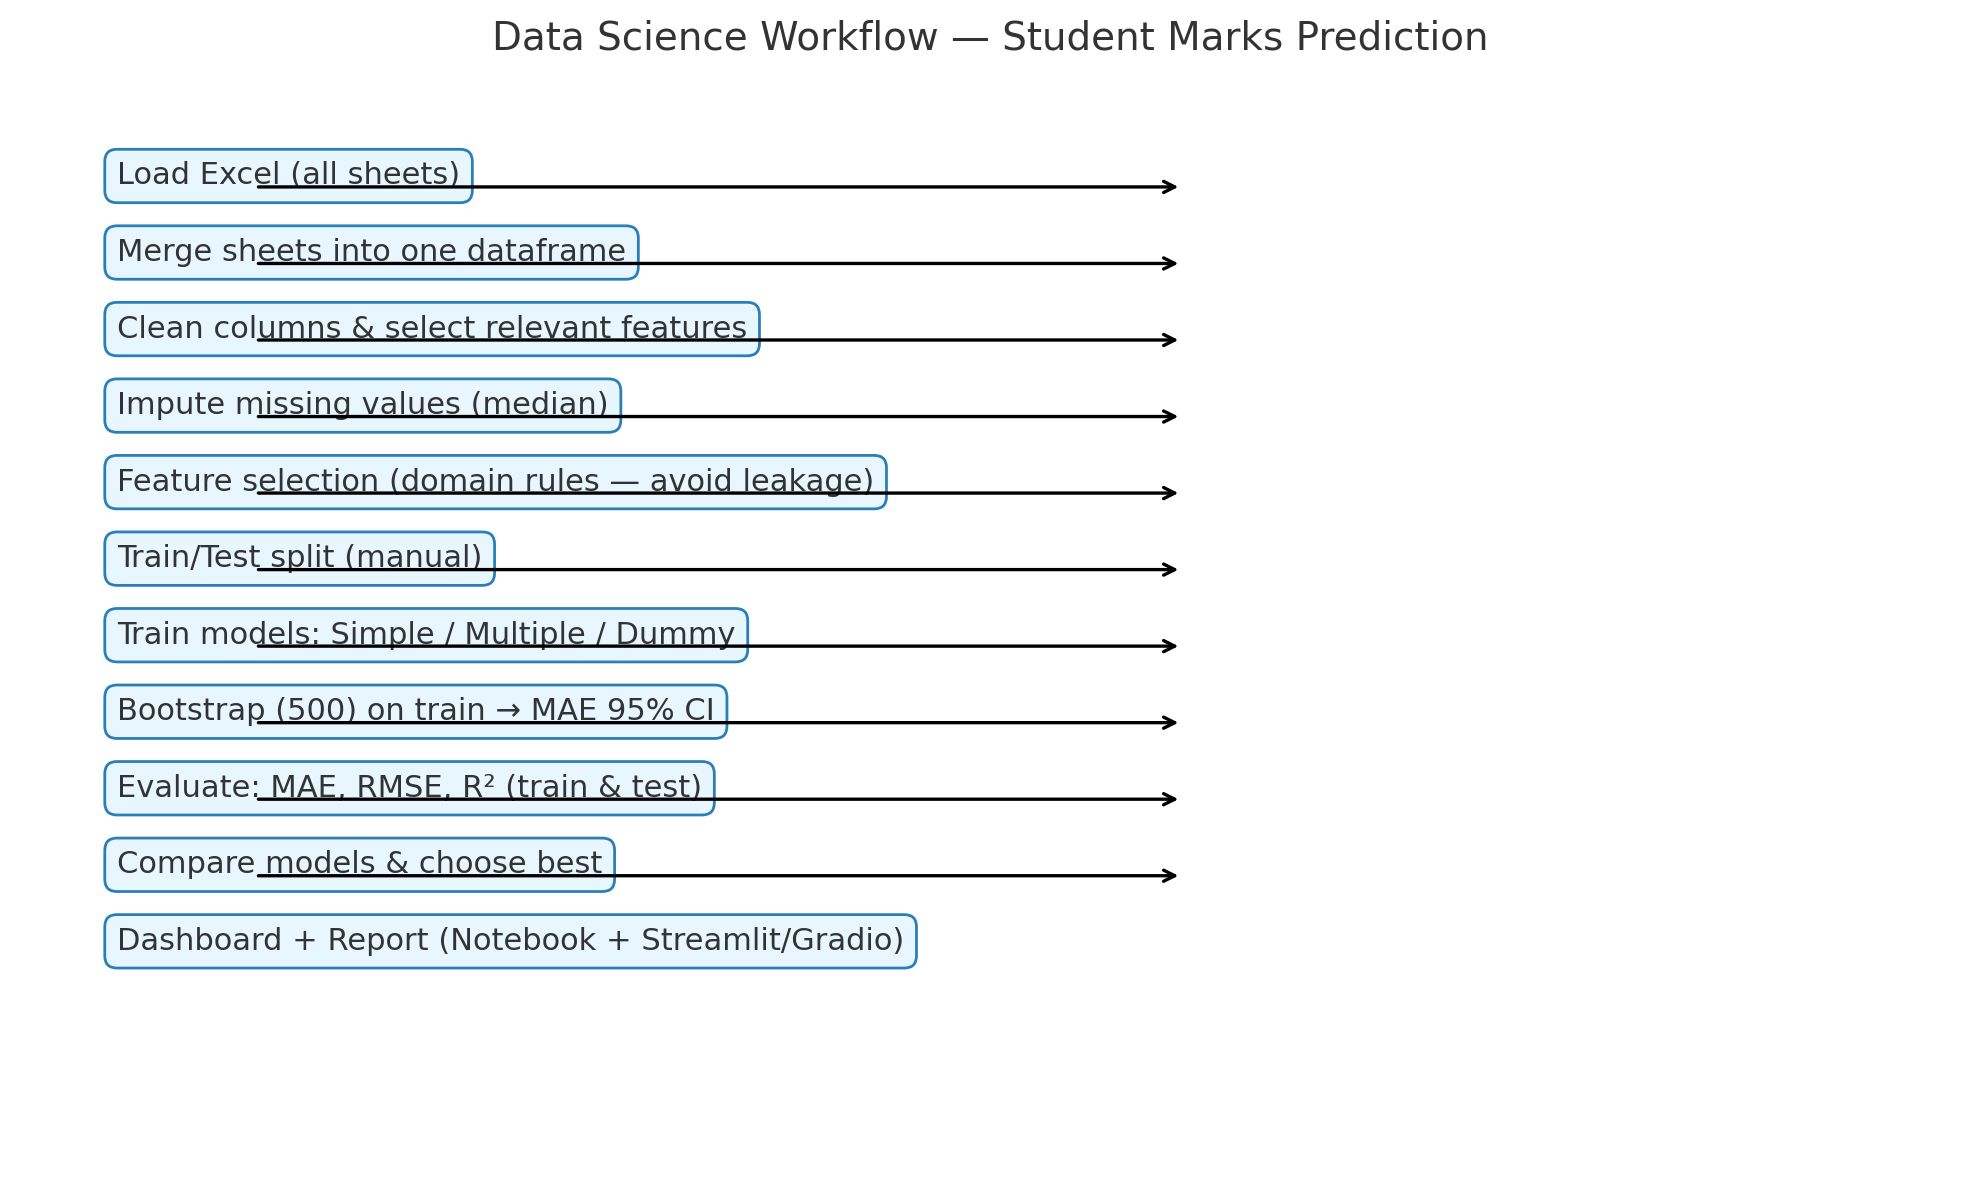